Neste notebook, usaremos o dataset de Delaney (https://doi.org/10.1021/ci034243x) para um exemplo de problema de regressão com redes neurais. Iremos utilizar algumas propriedades moleculares para tentar prever a solubilidade de moléculas.

Para começar, importaremos o básico: Keras, Pandas e Matplotlib, todos disponíveis previamente no Colab.

In [65]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

O Colab possui alguns banco de dados já disponíveis para modelos de ML. Aqui, iremos fazer o upload do dataset do Delaney.

Você pode fazer o upload do arquivo no diretório atual, na pasta com dados (sample_data) ou criar uma pasta nova.

In [66]:
!ls sample_data

anscombe.json		     california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv		   README.md


O Pandas permite ler diretamente arquivos csv e txt, já carregando diretamente o nome das colunas (quando especificado no arquivo).

In [67]:
delaney = pd.read_csv("delaney-processed.csv")

delaney.head()


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


Inicialmente iremos separar o alvo, neste caso o log da solubilidade em mol/L. Precisaremos converter como array para usá-lo no Keras.

In [68]:
target_ar = np.array(delaney["measured log solubility in mols per litre"], dtype=np.float32)
target_ar

array([-0.77 , -3.3  , -2.06 , ..., -3.091, -3.18 , -4.522], dtype=float32)

Agora iremos separar as features (características) do modelo que serão utilizadas para prever a solubilidade dos compostos.

In [69]:
delaney_feat = delaney.drop(columns=['measured log solubility in mols per litre', "ESOL predicted log solubility in mols per litre", "Compound ID", "smiles"])

In [70]:
delaney_feat

,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area
0,1,457.432,7,3,7,202.32
1,1,201.225,1,2,2,42.24
2,1,152.237,0,0,4,17.07
3,2,278.354,0,5,0,0.00
4,2,84.143,0,1,0,0.00
...,...,...,...,...,...,...
1123,1,197.381,0,0,0,0.00
1124,1,219.266,1,0,1,71.00
1125,1,246.359,0,0,7,18.46
1126,1,72.151,0,0,1,0.00


Precisamos converter também as features para arrays.

In [71]:
delaney_afeat = np.array(delaney_feat)
delaney_afeat

array([[  1.   , 457.432,   7.   ,   3.   ,   7.   , 202.32 ],
       [  1.   , 201.225,   1.   ,   2.   ,   2.   ,  42.24 ],
       [  1.   , 152.237,   0.   ,   0.   ,   4.   ,  17.07 ],
       ...,
       [  1.   , 246.359,   0.   ,   0.   ,   7.   ,  18.46 ],
       [  1.   ,  72.151,   0.   ,   0.   ,   1.   ,   0.   ],
       [  1.   , 365.964,   0.   ,   1.   ,   5.   ,  44.76 ]])

In [72]:
delaney_afeat.shape

(1128, 6)

In [73]:
target_ar.shape

(1128,)

In [74]:
num_test_samples = int(0.1 * len(delaney_afeat))
train_data = delaney_afeat[:-num_test_samples]
train_targets = target_ar[:-num_test_samples]

test_data = delaney_afeat[-num_test_samples:]
test_targets = target_ar[-num_test_samples:]

In [75]:
train_data.shape

(1016, 6)

In [76]:
train_targets.shape

(1016,)

É importante que os descritores tenham uma distribuição homogêna; assim, os centralizamos para a média e normalizamos em relação ao desvio-padrão.

In [77]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data -= mean
train_data /= std
test_data -= mean
test_data /= std

In [78]:
train_targets

array([-0.77 , -3.3  , -2.06 , ..., -2.863, -3.22 , -6.68 ], dtype=float32)

Até agora, só fizemos tratamento de dados. Agora iremos construir o modelo. Utilizaremos o RMSProp como otimizador e a MAE (mean absolute error) como métrica.

In [79]:
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(1)
      ])
  model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
  return model

Neste exemplo, temos poucos exemplos (cerca de 1100). Assim, separar parte dos exemplos para validar o modelo é complicado, pois a quantidade de exemplos para validação (no máximo 30%) seria muito pequena.
Assim, usaremos uma técnica de validação k-fold (ou validação cruzada). Os exemplos são divididos em um certo número $k$ de pastas, e o modelo é treinado no conjunto $k-1$ e validado em $k$. Isso é revezado em todas as pastas.

In [80]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
all_mae_histories = []
for i in range(k):
  print(f"Processing fold #{i}")
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
       train_data[(i + 1) * num_val_samples:]],
      axis=0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]],
      axis=0)

  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets,
  validation_data=(val_data, val_targets),
                      epochs=num_epochs, batch_size=16, verbose=0)
  mae_history = history.history["val_mae"]
  all_mae_histories.append(mae_history)

  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)
  mae_history = history.history["val_mae"]
  all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


Podemos verificar o escore em cada uma das validações e sua média.

In [81]:
all_scores

[0.6217065453529358, 0.6428847908973694, 0.679298996925354, 0.7306104302406311]

In [82]:
np.mean(all_scores)

np.float64(0.6686251908540726)

Agora iremos plotar a MAE (média das pastas) em relação ao número de épocas de treinamento.

In [83]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

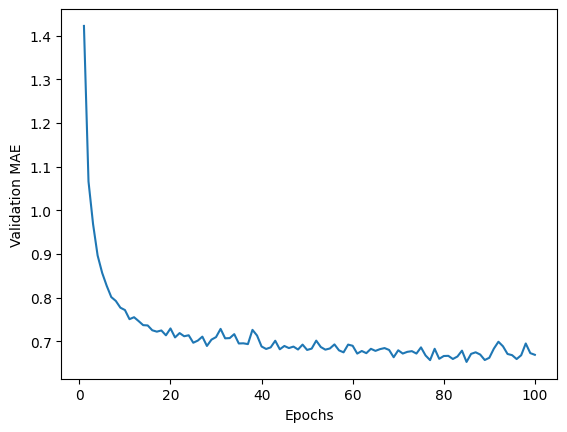

In [84]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [85]:
predictions = model.predict(train_data[32:33])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [86]:
predictions[0], train_targets[22]

(array([-3.506618], dtype=float32), np.float32(-4.11))

Depois tente rodar o mesmo problema em 500 épocas, e avalie a diferença de desempenho do modelo.

In [87]:
#num_epochs = 500
#all_mae_histories = []
#for i in range(k):
#  print(f"Processing fold #{i}")
#  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
#  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
#  partial_train_data = np.concatenate(
#      [train_data[:i * num_val_samples],
#       train_data[(i + 1) * num_val_samples:]],
#      axis=0)
#  partial_train_targets = np.concatenate(
#      [train_targets[:i * num_val_samples],
#       train_targets[(i + 1) * num_val_samples:]],
#      axis=0)
#
#  model = build_model()
#  history = model.fit(partial_train_data, partial_train_targets,
#  validation_data=(val_data, val_targets),
#                      epochs=num_epochs, batch_size=16, verbose=0)
#  mae_history = history.history["val_mae"]
#  all_mae_histories.append(mae_history)